In [ ]:
from warnings import filterwarnings
filterwarnings("ignore")

In [ ]:
import pandas as pd

# Load the dataset
path = r"C:\Users\Saurav Mali\Downloads\Cabbage\2015-2024\2015-2024.csv"
df = pd.read_csv(path, na_values=["", "NA"], keep_default_na=False)

# Convert 'Arrival Date' to datetime
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'], format='%d-%m-%Y', errors='coerce')

# Convert 'Modal Price(Rs./Quintal)' to numeric
df['Modal Price(Rs./Quintal)'] = pd.to_numeric(df['Modal Price(Rs./Quintal)'], errors='coerce')

# Drop rows where important data is missing
df.dropna(subset=['Arrival Date', 'Modal Price(Rs./Quintal)'], inplace=True)

# ✅ Filter rows where Modal Price >= 1000
filtered_df = df[df['Modal Price(Rs./Quintal)'] >= 1000]

# Extract Year and Month
filtered_df['Year'] = filtered_df['Arrival Date'].dt.year
filtered_df['Month'] = filtered_df['Arrival Date'].dt.month

# OPTIONAL: Format 'Arrival Date' back to string format like '01-08-2015'
filtered_df['Arrival Date'] = filtered_df['Arrival Date'].dt.strftime('%d-%m-%Y')

# Keep only needed columns
final_filtered = filtered_df[['Arrival Date', 'Year', 'Month', 'Modal Price(Rs./Quintal)']]

# Save the filtered data to CSV
output_path = r"C:\Users\Saurav Mali\Downloads\modal_price_greater_1000.csv"
final_filtered.to_csv(output_path, index=False)

print(f"✅ Data where Modal Price >= 1000 saved successfully to {output_path}")


Linear Regression: Mean Squared Error (MSE) = 384616.3169029517
Random Forest: Mean Squared Error (MSE) = 324817.1133590329
Gradient Boosting: Mean Squared Error (MSE) = 329266.2239974982
Support Vector Regressor: Mean Squared Error (MSE) = 410442.41045614786
Optimal selling dates for 2025 have been saved to: C:\Users\Saurav Mali\Downloads\Cabbage\Optimal_Selling_Dates_2025.csv


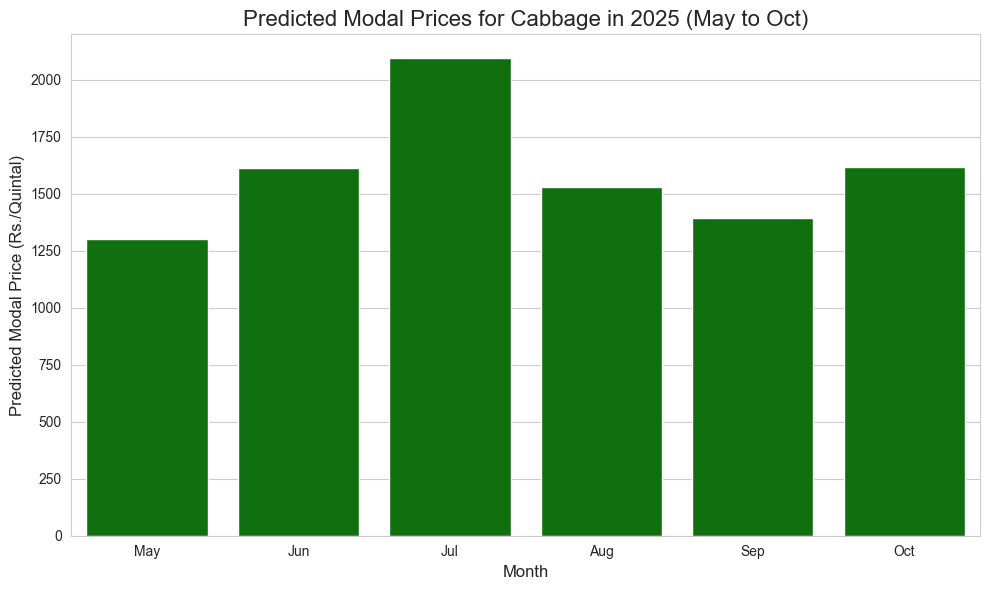

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Load the dataset
path = r"C:\Users\Saurav Mali\Downloads\Cabbage\2015-2024\2015-2024.csv"
df = pd.read_csv(path, na_values=["", "NA"], keep_default_na=False)

# Convert 'Arrival Date' to datetime
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'], format='%d-%m-%Y', errors='coerce')

# Convert 'Modal Price(Rs./Quintal)' to numeric
df['Modal Price(Rs./Quintal)'] = pd.to_numeric(df['Modal Price(Rs./Quintal)'], errors='coerce')

# Drop rows where important data is missing
df.dropna(subset=['Arrival Date', 'Modal Price(Rs./Quintal)'], inplace=True)

# Filter rows where Modal Price >= 1000
filtered_df = df[df['Modal Price(Rs./Quintal)'] >= 1000]

# Extract Year and Month
filtered_df['Year'] = filtered_df['Arrival Date'].dt.year
filtered_df['Month'] = filtered_df['Arrival Date'].dt.month

# Filter only for months between May (5) and October (10)
filtered_df = filtered_df[filtered_df['Month'].isin([5, 6, 7, 8, 9, 10])]

# Prepare data for model (using Year and Month to predict Modal Price)
X = filtered_df[['Year', 'Month']]  # Features: Year and Month
y = filtered_df['Modal Price(Rs./Quintal)']  # Target: Modal Price

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models for comparison
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

# Initialize variables to keep track of the best model
best_model = None
best_model_name = None
best_score = float('inf')  # We are minimizing the MSE

# Perform cross-validation and evaluate each model
for model_name, model in models.items():
    # Perform cross-validation and get the mean score (negative MSE)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -cv_scores.mean()  # Convert negative MSE to positive

    print(f"{model_name}: Mean Squared Error (MSE) = {mean_score}")

    # Update the best model if this one performs better
    if mean_score < best_score:
        best_score = mean_score
        best_model_name = model_name
        best_model = model

# Train the best model on the full training data
best_model.fit(X_train, y_train)

# Predict the Modal Prices for 2025 (for months May to October)
predict_2025 = pd.DataFrame({
    'Year': [2025] * 6,  # Year 2025
    'Month': [5, 6, 7, 8, 9, 10]  # Months from May to October
})

# Generate the date column (using the 1st day of each month)
predict_2025['Date'] = pd.to_datetime(predict_2025[['Year', 'Month']].assign(DAY=1))

# Predict the Modal Prices for 2025 using the best model
predicted_prices_2025 = best_model.predict(predict_2025[['Year', 'Month']])

# Add predicted prices to the dataframe
predict_2025['Predicted Modal Price'] = predicted_prices_2025

# =========================================================
# 📈 Optimal Selling Dates Based on Maximum Predicted Price
# =========================================================

# For each month, find the maximum predicted price and the corresponding date(s)
optimal_selling_dates = []
for month in range(5, 11):  # May to October
    # Filter data for the given month in 2025
    month_data = predict_2025[predict_2025['Month'] == month]
    
    # Find the maximum predicted price for the month
    max_price = month_data['Predicted Modal Price'].max()
    
    # Get the date(s) corresponding to the maximum price
    best_dates = month_data[month_data['Predicted Modal Price'] == max_price]['Date']
    
    # Append the month, date, and price to the list
    for date in best_dates:
        optimal_selling_dates.append({
            'Month': month,
            'Date': date,
            'Year': 2025,
            'Predicted Modal Price': max_price
        })

# Convert the list to a DataFrame
optimal_selling_dates_df = pd.DataFrame(optimal_selling_dates)

# Save the optimal selling dates to a CSV file
output_path = r"C:\Users\Saurav Mali\Downloads\Cabbage\Optimal_Selling_Dates_2025.csv"
optimal_selling_dates_df.to_csv(output_path, index=False)

# Print a message confirming the file has been saved
print(f"Optimal selling dates for 2025 have been saved to: {output_path}")

# =========================================================
# 📈 VISUALIZATION PART
# =========================================================

# Plotting the predicted Modal Prices for 2025
plt.figure(figsize=(10, 6))
sns.barplot(x=predict_2025['Month'], y=predict_2025['Predicted Modal Price'], color='green')

# Add titles and labels
plt.title('Predicted Modal Prices for Cabbage in 2025 (May to Oct)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Predicted Modal Price (Rs./Quintal)', fontsize=12)
plt.xticks(ticks=range(6), labels=['May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])

# Show the plot
plt.tight_layout()
plt.show()


Linear Regression: Mean Squared Error (MSE) = 384604.51578974305
Random Forest: Mean Squared Error (MSE) = 319953.67986273096
Gradient Boosting: Mean Squared Error (MSE) = 325395.00362583186
Support Vector Regressor: Mean Squared Error (MSE) = 410435.8079604452
Optimal selling dates for 2025 (weekly) have been saved to: C:\Users\Saurav Mali\Downloads\Cabbage\Optimal_Selling_Dates_Weekly_2025.csv


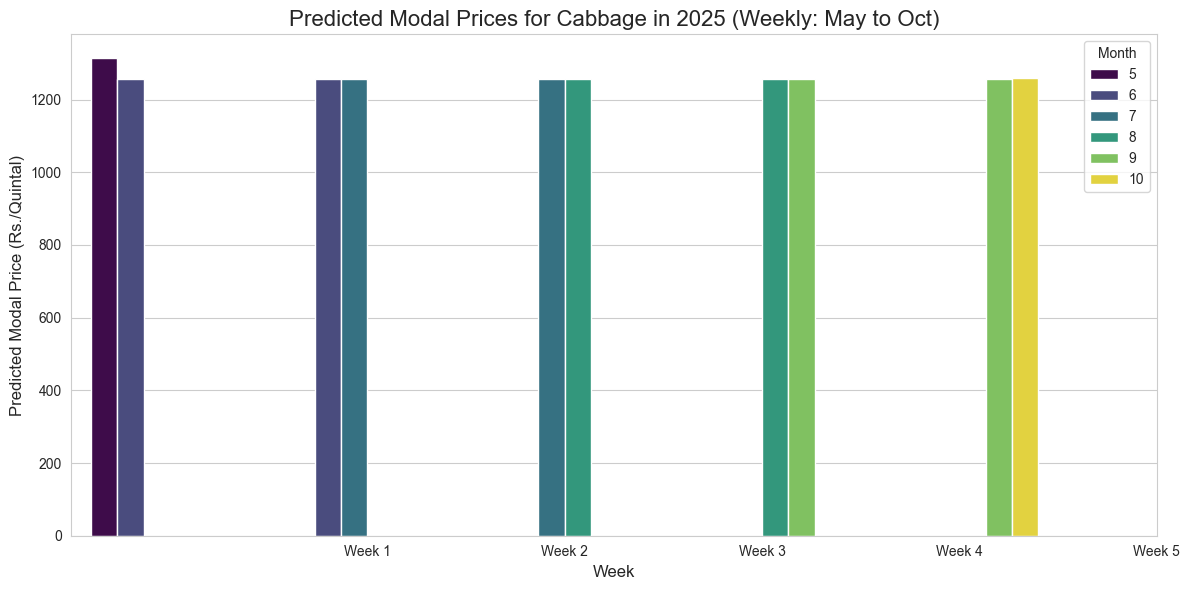

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Load the dataset
path = r"C:\Users\Saurav Mali\Downloads\Cabbage\2015-2024\2015-2024.csv"
df = pd.read_csv(path, na_values=["", "NA"], keep_default_na=False)

# Convert 'Arrival Date' to datetime
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'], format='%d-%m-%Y', errors='coerce')

# Convert 'Modal Price(Rs./Quintal)' to numeric
df['Modal Price(Rs./Quintal)'] = pd.to_numeric(df['Modal Price(Rs./Quintal)'], errors='coerce')

# Drop rows where important data is missing
df.dropna(subset=['Arrival Date', 'Modal Price(Rs./Quintal)'], inplace=True)

# Filter rows where Modal Price >= 1000
filtered_df = df[df['Modal Price(Rs./Quintal)'] >= 1000]

# Extract Year and Month
filtered_df['Year'] = filtered_df['Arrival Date'].dt.year
filtered_df['Month'] = filtered_df['Arrival Date'].dt.month

# Filter only for months between May (5) and October (10)
filtered_df = filtered_df[filtered_df['Month'].isin([5, 6, 7, 8, 9, 10])]

# Add Week number
filtered_df['Week'] = filtered_df['Arrival Date'].dt.isocalendar().week

# Prepare data for model (using Year, Month, and Week to predict Modal Price)
X = filtered_df[['Year', 'Month', 'Week']]  # Features: Year, Month, and Week
y = filtered_df['Modal Price(Rs./Quintal)']  # Target: Modal Price

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models for comparison
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

# Initialize variables to keep track of the best model
best_model = None
best_model_name = None
best_score = float('inf')  # We are minimizing the MSE

# Perform cross-validation and evaluate each model
for model_name, model in models.items():
    # Perform cross-validation and get the mean score (negative MSE)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -cv_scores.mean()  # Convert negative MSE to positive

    print(f"{model_name}: Mean Squared Error (MSE) = {mean_score}")

    # Update the best model if this one performs better
    if mean_score < best_score:
        best_score = mean_score
        best_model_name = model_name
        best_model = model

# Train the best model on the full training data
best_model.fit(X_train, y_train)

# Predict the Modal Prices for 2025 (for months May to October)
predict_2025 = pd.DataFrame({
    'Year': [2025] * 6 * 5,  # Year 2025
    'Month': [month for month in range(5, 11) for _ in range(1, 6)],  # Weeks for each month (1-5 weeks)
    'Week': [week for week in range(1, 6) for _ in range(5, 11)]  # 5 weeks per month
})

# Generate the date column (using the 1st day of each month and weekly intervals)
predict_2025['Date'] = pd.to_datetime(predict_2025[['Year', 'Month']].assign(DAY=1))

# Predict the Modal Prices for 2025 using the best model
predicted_prices_2025 = best_model.predict(predict_2025[['Year', 'Month', 'Week']])

# Add predicted prices to the dataframe
predict_2025['Predicted Modal Price'] = predicted_prices_2025

# =========================================================
# 📈 Optimal Selling Dates Based on Maximum Predicted Price (Weekly)
# =========================================================

# For each week in 2025, find the maximum predicted price and the corresponding date(s)
optimal_selling_dates_weekly = []
for month in range(5, 11):  # May to October
    for week in range(1, 6):  # Weeks 1 to 5
        # Filter data for the given month and week in 2025
        week_data = predict_2025[(predict_2025['Month'] == month) & (predict_2025['Week'] == week)]
        
        # Find the maximum predicted price for the week
        max_price = week_data['Predicted Modal Price'].max()
        
        # Get the date(s) corresponding to the maximum price
        best_dates = week_data[week_data['Predicted Modal Price'] == max_price]['Date']
        
        # Append the month, week, date, and price to the list
        for date in best_dates:
            optimal_selling_dates_weekly.append({
                'Month': month,
                'Week': week,
                'Date': date,
                'Year': 2025,
                'Predicted Modal Price': max_price
            })

# Convert the list to a DataFrame
optimal_selling_dates_weekly_df = pd.DataFrame(optimal_selling_dates_weekly)

# Save the optimal selling dates to a CSV file
output_path_weekly = r"C:\Users\Saurav Mali\Downloads\Cabbage\Optimal_Selling_Dates_Weekly_2025.csv"
optimal_selling_dates_weekly_df.to_csv(output_path_weekly, index=False)

# Print a message confirming the file has been saved
print(f"Optimal selling dates for 2025 (weekly) have been saved to: {output_path_weekly}")

# =========================================================
# 📈 VISUALIZATION PART
# =========================================================

# Plotting the predicted Modal Prices for 2025 by Week
plt.figure(figsize=(12, 6))
sns.barplot(x=predict_2025['Week'], y=predict_2025['Predicted Modal Price'], hue=predict_2025['Month'], palette='viridis')

# Add titles and labels
plt.title('Predicted Modal Prices for Cabbage in 2025 (Weekly: May to Oct)', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Predicted Modal Price (Rs./Quintal)', fontsize=12)
plt.xticks(ticks=range(1, 6), labels=['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5'])

# Show the plot
plt.tight_layout()
plt.show()


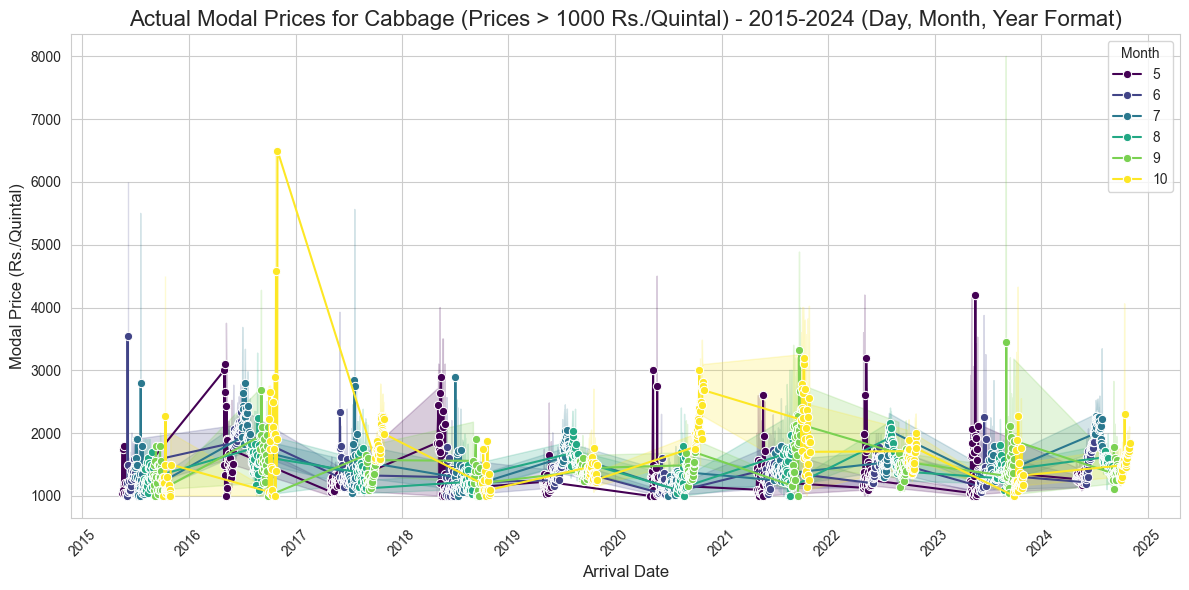

In [63]:
# Filter data for Modal Price greater than 1000
filtered_actual_df = df[df['Modal Price(Rs./Quintal)'] >= 1000]

# Extract Year, Month, and Day for the filtered data
filtered_actual_df['Year'] = filtered_actual_df['Arrival Date'].dt.year
filtered_actual_df['Month'] = filtered_actual_df['Arrival Date'].dt.month
filtered_actual_df['Day'] = filtered_actual_df['Arrival Date'].dt.day

# Filter only for months between May (5) and October (10)
filtered_actual_df = filtered_actual_df[filtered_actual_df['Month'].isin([5, 6, 7, 8, 9, 10])]

# Visualization of actual Modal Price for the filtered data (greater than 1000) with day, month, and year format
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_actual_df, x='Arrival Date', y='Modal Price(Rs./Quintal)', hue='Month', palette='viridis', marker='o')

# Add titles and labels
plt.title('Actual Modal Prices for Cabbage (Prices > 1000 Rs./Quintal) - 2015-2024 (Day, Month, Year Format)', fontsize=16)
plt.xlabel('Arrival Date', fontsize=12)
plt.ylabel('Modal Price (Rs./Quintal)', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [64]:
import os

# Define the output folder where CSVs and plots will be saved
output_folder = r"C:\Users\Saurav Mali\Downloads\Cabbage\Separated_By_Year"
os.makedirs(output_folder, exist_ok=True)

# Filter data for Modal Price greater than 1000
filtered_actual_df = df[df['Modal Price(Rs./Quintal)'] >= 1000]

# Extract Year, Month, and Day
filtered_actual_df['Year'] = filtered_actual_df['Arrival Date'].dt.year
filtered_actual_df['Month'] = filtered_actual_df['Arrival Date'].dt.month
filtered_actual_df['Day'] = filtered_actual_df['Arrival Date'].dt.day

# Filter only for months between May (5) and October (10)
filtered_actual_df = filtered_actual_df[filtered_actual_df['Month'].isin([5, 6, 7, 8, 9, 10])]

# Unique years present in the filtered dataset
years = filtered_actual_df['Year'].unique()

# Process each year separately
for year in sorted(years):
    # Filter data for the specific year
    year_df = filtered_actual_df[filtered_actual_df['Year'] == year]
    
    if not year_df.empty:
        # Save year-wise CSV
        output_csv_path = os.path.join(output_folder, f'Cabbage_Modal_Prices_{year}.csv')
        year_df.to_csv(output_csv_path, index=False)
        print(f"Saved CSV for {year}: {output_csv_path}")
        
        # Plotting the data for the year
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=year_df, x='Arrival Date', y='Modal Price(Rs./Quintal)', hue='Month', palette='viridis', marker='o')

        plt.title(f'Cabbage Modal Prices > 1000 Rs./Quintal - {year}', fontsize=16)
        plt.xlabel('Arrival Date', fontsize=12)
        plt.ylabel('Modal Price (Rs./Quintal)', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Save the plot as PNG
        output_plot_path = os.path.join(output_folder, f'Cabbage_Modal_Prices_{year}.png')
        plt.savefig(output_plot_path)
        plt.close()  # Close the figure after saving to avoid overlap

        print(f"Saved Plot for {year}: {output_plot_path}")


Saved CSV for 2015: C:\Users\Saurav Mali\Downloads\Cabbage\Separated_By_Year\Cabbage_Modal_Prices_2015.csv
Saved Plot for 2015: C:\Users\Saurav Mali\Downloads\Cabbage\Separated_By_Year\Cabbage_Modal_Prices_2015.png
Saved CSV for 2016: C:\Users\Saurav Mali\Downloads\Cabbage\Separated_By_Year\Cabbage_Modal_Prices_2016.csv
Saved Plot for 2016: C:\Users\Saurav Mali\Downloads\Cabbage\Separated_By_Year\Cabbage_Modal_Prices_2016.png
Saved CSV for 2017: C:\Users\Saurav Mali\Downloads\Cabbage\Separated_By_Year\Cabbage_Modal_Prices_2017.csv
Saved Plot for 2017: C:\Users\Saurav Mali\Downloads\Cabbage\Separated_By_Year\Cabbage_Modal_Prices_2017.png
Saved CSV for 2018: C:\Users\Saurav Mali\Downloads\Cabbage\Separated_By_Year\Cabbage_Modal_Prices_2018.csv
Saved Plot for 2018: C:\Users\Saurav Mali\Downloads\Cabbage\Separated_By_Year\Cabbage_Modal_Prices_2018.png
Saved CSV for 2019: C:\Users\Saurav Mali\Downloads\Cabbage\Separated_By_Year\Cabbage_Modal_Prices_2019.csv
Saved Plot for 2019: C:\Users\Sau